In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import time
import pickle

import memory_profiler
%load_ext memory_profiler

from pathlib import Path

In [2]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize

# Download necessary NLTK data
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")
nltk.download("punkt")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sdoneva/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/sdoneva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sdoneva/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [6]:
%load_ext autoreload
%autoreload 2

import src
from src.plotting import (
    automatic_coloring,
    improved_coloring,
    years_coloring,
    plot_tsne_colors,
    plot_label_tags,
    plot_tsne_years,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
variables_path = Path("./data/variables/")
figures_path = Path("./viz/embeddings")
embeddings_data_path = Path("data/embeddings/")

In [8]:
plt.style.use("matplotlib_style.txt")

# Colors

## Import data

In [9]:
df = pd.read_csv(
    "data/annotated_aact/normalized_annotations_unique_19607_with_details.csv"
)

In [10]:
df.head()

Unnamed: 0       nct_id canonical_BioLinkBERT-base_interventions  \
0           0  NCT00000117          intravenous immunoglobulin|ivig   
1          12  NCT00000146                           corticosteroid   
2         108  NCT00000147                           corticosteroid   
3         204  NCT00000151             acetylsalicylic acid|aspirin   
4         524  NCT00000170                                 atropine   

               canonical_BioLinkBERT-base_conditions  \
0                  multiple sclerosis|optic neuritis   
1                  multiple sclerosis|optic neuritis   
2                  multiple sclerosis|optic neuritis   
3  blindness|diabetes mellitus|diabetic retinopat...   
4  amblyopia|anisometropia|moderate amblyopia|str...   

                                   Disease Class  \
0                         Cranial Nerve Diseases   
1  Cranial Nerve Diseases|Demyelinating Diseases   
2  Cranial Nerve Diseases|Demyelinating Diseases   
3              Neurologic Manifestations|unknown   
4                      Neurologic Manifestations   

                                         brief_title  \
0  Intravenous Immunoglobulin Therapy in Optic Ne...   
1              Optic Neuritis Treatment Trial (ONTT)   
2           Longitudinal Optic Neuritis Study (LONS)   
3  Early Treatment Diabetic Retinopathy Study (ET...   
4  Occlusion Versus Pharmacologic Therapy for Mod...   

                                study_official_title  \
0  Intravenous Immunoglobulin Therapy in Optic Ne...   
1              Optic Neuritis Treatment Trial (ONTT)   
2           Longitudinal Optic Neuritis Study (LONS)   
3  Early Treatment Diabetic Retinopathy Study (ET...   
4  Amblyopia Treatment Study: Occlusion Versus Ph...   

                           brief_summary_description  
0  To determine whether high-dose intravenous imm...  
1  To assess the beneficial and adverse effects o...  
2  To assess the beneficial and adverse effects o...  
3  To evaluate the effectiveness of both argon la...  
4  To determine whether the success rate with dru...

In [11]:
df["trial_title_summary"] = (
    df["brief_title"].fillna("")
    + " | "
    + df["study_official_title"].fillna("")
    + " | "
    + df["brief_summary_description"].fillna("")
    + " | "
    + df["canonical_BioLinkBERT-base_interventions"].fillna("")
)

In [12]:
df.shape

(19607, 9)

### load umap

In [13]:
umap_reparsed = np.load(variables_path / "umap_reparsed.npy")

In [14]:
umap = np.vstack((-umap_reparsed[:, 0], umap_reparsed[:, 1])).T

In [15]:
umap.shape

(19607, 2)

## Preprocess

In [16]:
# Function to lemmatize a sentence
def lemmatize_sentence(sentence):
    lemmatizer = WordNetLemmatizer()
    # Tokenize the sentence
    tokens = word_tokenize(sentence)
    # Lemmatize each token with its correct POS tag
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Combine the lemmatized tokens back into a single string
    return " ".join(lemmatized_tokens)

In [17]:
# df["lemmatized_trial_title_summary"] = df["trial_title_summary"].apply(
#    lambda x: lemmatize_sentence(x)
# )

In [18]:
df.head()

Unnamed: 0       nct_id canonical_BioLinkBERT-base_interventions  \
0           0  NCT00000117          intravenous immunoglobulin|ivig   
1          12  NCT00000146                           corticosteroid   
2         108  NCT00000147                           corticosteroid   
3         204  NCT00000151             acetylsalicylic acid|aspirin   
4         524  NCT00000170                                 atropine   

               canonical_BioLinkBERT-base_conditions  \
0                  multiple sclerosis|optic neuritis   
1                  multiple sclerosis|optic neuritis   
2                  multiple sclerosis|optic neuritis   
3  blindness|diabetes mellitus|diabetic retinopat...   
4  amblyopia|anisometropia|moderate amblyopia|str...   

                                   Disease Class  \
0                         Cranial Nerve Diseases   
1  Cranial Nerve Diseases|Demyelinating Diseases   
2  Cranial Nerve Diseases|Demyelinating Diseases   
3              Neurologic Manifestations|unknown   
4                      Neurologic Manifestations   

                                         brief_title  \
0  Intravenous Immunoglobulin Therapy in Optic Ne...   
1              Optic Neuritis Treatment Trial (ONTT)   
2           Longitudinal Optic Neuritis Study (LONS)   
3  Early Treatment Diabetic Retinopathy Study (ET...   
4  Occlusion Versus Pharmacologic Therapy for Mod...   

                                study_official_title  \
0  Intravenous Immunoglobulin Therapy in Optic Ne...   
1              Optic Neuritis Treatment Trial (ONTT)   
2           Longitudinal Optic Neuritis Study (LONS)   
3  Early Treatment Diabetic Retinopathy Study (ET...   
4  Amblyopia Treatment Study: Occlusion Versus Ph...   

                           brief_summary_description  \
0  To determine whether high-dose intravenous imm...   
1  To assess the beneficial and adverse effects o...   
2  To assess the beneficial and adverse effects o...   
3  To evaluate the effectiveness of both argon la...   
4  To determine whether the success rate with dru...   

                                 trial_title_summary  
0  Intravenous Immunoglobulin Therapy in Optic Ne...  
1  Optic Neuritis Treatment Trial (ONTT) | Optic ...  
2  Longitudinal Optic Neuritis Study (LONS) | Lon...  
3  Early Treatment Diabetic Retinopathy Study (ET...  
4  Occlusion Versus Pharmacologic Therapy for Mod...

In [19]:
# df.to_csv("df_with_lemma.csv")

## Colors based on keywords

In [20]:
"""
Description of colors and words below.

Colors:
-chosen_colors: colors chosen manually from Scanpy colors selection 
(originally from http://godsnotwheregodsnot.blogspot.com/2013/11/kmeans-color-quantization-seeding.html)

Words:
-words_capital: Words selected manually from the 100 most relevant words using threshold 0.1.
"""

# COLORS
chosen_colors = [
    "black",
    "#aeaa00",
    "#1CE6FF",
    "#FF34FF",
    "#FF4A46",
    "#008941",
    "#006FA6",
    "#0089A3",
    "#0000A6",
    "#B79762",
    "#004D43",
    "#8FB0FF",
    "#5A0007",
    "#BA0900",
    "#1B4400",
    "#4FC601",
    "#3B5DFF",
    "#00C2A0",
    "#549E79",
    "#BC23FF",
    "#C895C5",
    "#FF2F80",
    "#009271",
    "#00FECF",
    "#A4E804",
    "#FFB500",
    "#6B002C",
    "#FF9408",
    "#CC0744",
    "#D790FF",
    "#5B4534",
    "#E83000",
    "#6F0062",
    "#b65141",
    "#C20078",
    "#7A4900",
    "#FF90C9",
    "#6508ba",
]
# WORDS
words = [
    "dystrophy",
    "cocaine",
    "stroke",
    "delirium",
    "cancer",
    "sleep",
    "tumor",
    "opioid",
    "ataxia",
    "pharmacokinetic",
    "fibromyalgia",
    "fabry disease",
    "dementia",
    "withdrawal",
    "tourette",
    "autism",
    "vaccine",
    "dependence",
    "spinal",
    "erectile dysfunction",
    "seizures",
    "lateral sclerosis",
    "diabetes",
    "smoking",
    "anxiety",
    "epilepsy",
    "OCD",
    "migraine",
    "stress",
    "neonatal",
    "bipolar",
    "hemorrhage",
    "multiple sclerosis",
    "depression",
    "alzheimer",
    "pain",
    "parkinson",
    "schizophrenia",
]

In [21]:
nsc_words = [
    "plasticity",
    "visual",
    "auditory",
    "parkinson",
    "learning",
    "memory",
    "sleep",
    "depression",
    "cognitive",
    "olfactory",
    "alzheimer",
    "social",
    "pain",
    "attention",
    "prefrontal",
    "temporal",
    "schizophrenia",
    "retina",
    "stress",
    "sensory",
    "cerebellar",
    "hippocampus",
    "motor",
    "perception",
    "age",
    "behavioral",
    "stroke",
    "epilepsy",
    "reward",
    "imaging",
    "fear",
    "astrocytes",
    "sclerosis",
    "dependence",
    "migraine",
    "tumor",
    "bipolar",
    "pharmacokinetic",
]

In [22]:
len(nsc_words), len(words)

(38, 38)

In [23]:
df["trial_title_summary"] = df["trial_title_summary"].str.replace(
    r"\bsmoker(s)?\b", "smoking", case=False, regex=True
)
df["trial_title_summary"] = df["trial_title_summary"].str.replace(
    r"\bdepressive\b", "depression", case=False, regex=True
)
df["trial_title_summary"] = df["trial_title_summary"].str.replace(
    r"\bopiate\b", "opioid", case=False, regex=True
)
df["trial_title_summary"] = df["trial_title_summary"].str.replace(
    r"\binsomnia\b", "sleep disorder", case=False, regex=True
)
df["trial_title_summary"] = df["trial_title_summary"].str.replace(
    r"\bschizophrenic\b", "schizophrenia", case=False, regex=True
)
df["trial_title_summary"] = df["trial_title_summary"].str.replace(
    r"\bvaccines\b", "vaccine", case=False, regex=True
)

In [24]:
len(chosen_colors), len(words)

(38, 38)

In [25]:
colors_new_legend = dict(zip(words, chosen_colors))

### assign cluster

In [26]:
%%time
labels_new, colors_new = improved_coloring(
    df["trial_title_summary"],
    colors_new_legend,
)

CPU times: user 910 ms, sys: 9.04 ms, total: 919 ms
Wall time: 921 ms


In [27]:
df["cluster"] = labels_new

In [28]:
cluster_sizes = df["cluster"].value_counts()

# Optionally, to convert it back to a DataFrame for better visualization or further processing:
cluster_sizes_df = cluster_sizes.reset_index().rename(
    columns={"index": "Cluster", "cluster": "Size"}
)

print(cluster_sizes_df)

                    Size  count
0              unlabeled   5276
1          schizophrenia   1470
2                   pain   1398
3             depression   1278
4              alzheimer   1142
5              parkinson   1060
6        pharmacokinetic    959
7                 stroke    576
8                  sleep    468
9                 stress    463
10               vaccine    441
11    multiple sclerosis    438
12              migraine    413
13              epilepsy    404
14               smoking    362
15                spinal    340
16                 tumor    331
17               bipolar    254
18            dependence    235
19                autism    197
20              seizures    183
21             dystrophy    166
22            hemorrhage    163
23               anxiety    158
24              delirium    153
25  erectile dysfunction    140
26                cancer    128
27              dementia    125
28              diabetes    110
29               cocaine    106
30      

In [29]:
df_no_cluster = df[df["cluster"] == "unlabeled"]
df_no_cluster.shape

(5276, 10)

In [30]:
counts = df_no_cluster["canonical_BioLinkBERT-base_conditions"].value_counts()
counts = counts.sort_values(ascending=False).head(30)

In [31]:
counts

canonical_BioLinkBERT-base_conditions
amyotrophic lateral sclerosis              55
multiple sclerosis                         37
cerebral palsy                             30
restless legs syndrome                     29
phenylketonuria|phenylketonurias           28
erectile dysfunction                       27
als|amyotrophic lateral sclerosis          27
huntington disease                         27
acromegaly                                 25
fragile x syndrome                         24
obsessive-compulsive disorder              23
brain injuries, traumatic                  23
sarcopenia                                 22
carpal tunnel syndrome                     22
rett syndrome                              21
als                                        21
neuralgia, postherpetic                    19
stress disorders, post-traumatic           19
panic disorder                             18
ms|multiple sclerosis                      17
prader-willi syndrome                     

In [32]:
df_no_cluster.to_csv("missing_cluster_nsc_words.csv")

In [33]:
len(labels_new)

19607

In [34]:
# save results
np.save(variables_path / "colors_new", colors_new)

# save results
f = open(variables_path / "colors_new_legend.pkl", "wb")
pickle.dump(colors_new_legend, f)
f.close()

### Plot

In [35]:
umap

array([[-2.5610092 ,  7.830954  ],
       [-2.511585  ,  8.159418  ],
       [-2.501308  ,  8.154861  ],
       ...,
       [ 0.81240475,  9.32759   ],
       [-0.29468518,  8.2760935 ],
       [-1.0257792 ,  7.6650767 ]], dtype=float32)

In [36]:
# load
# legend colors
pickle_in = open(variables_path / "colors_new_legend.pkl", "rb")
colors_new_legend = pickle.load(pickle_in)

colors_new = np.load(variables_path / "colors_new.npy", allow_pickle=True)

In [37]:
len(colors_new)

19607

In [38]:
len(umap)

19607

In [60]:
umap

array([[-2.5610092 ,  7.830954  ],
       [-2.511585  ,  8.159418  ],
       [-2.501308  ,  8.154861  ],
       ...,
       [ 0.81240475,  9.32759   ],
       [-0.29468518,  8.2760935 ],
       [-1.0257792 ,  7.6650767 ]], dtype=float32)

/Users/sdoneva/Documents/Work/In Progress/PhD/PhD Projects/In Progress/NeuroTrialAnalysis/src/plotting.py:442: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/Users/sdoneva/Documents/Work/In Progress/PhD/PhD Projects/In Progress/NeuroTrialAnalysis/src/plotting.py:438: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/Users/sdoneva/Documents/Work/In Progress/PhD/PhD Projects/In Progress/NeuroTrialAnalysis/src/plotting.py:458: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value

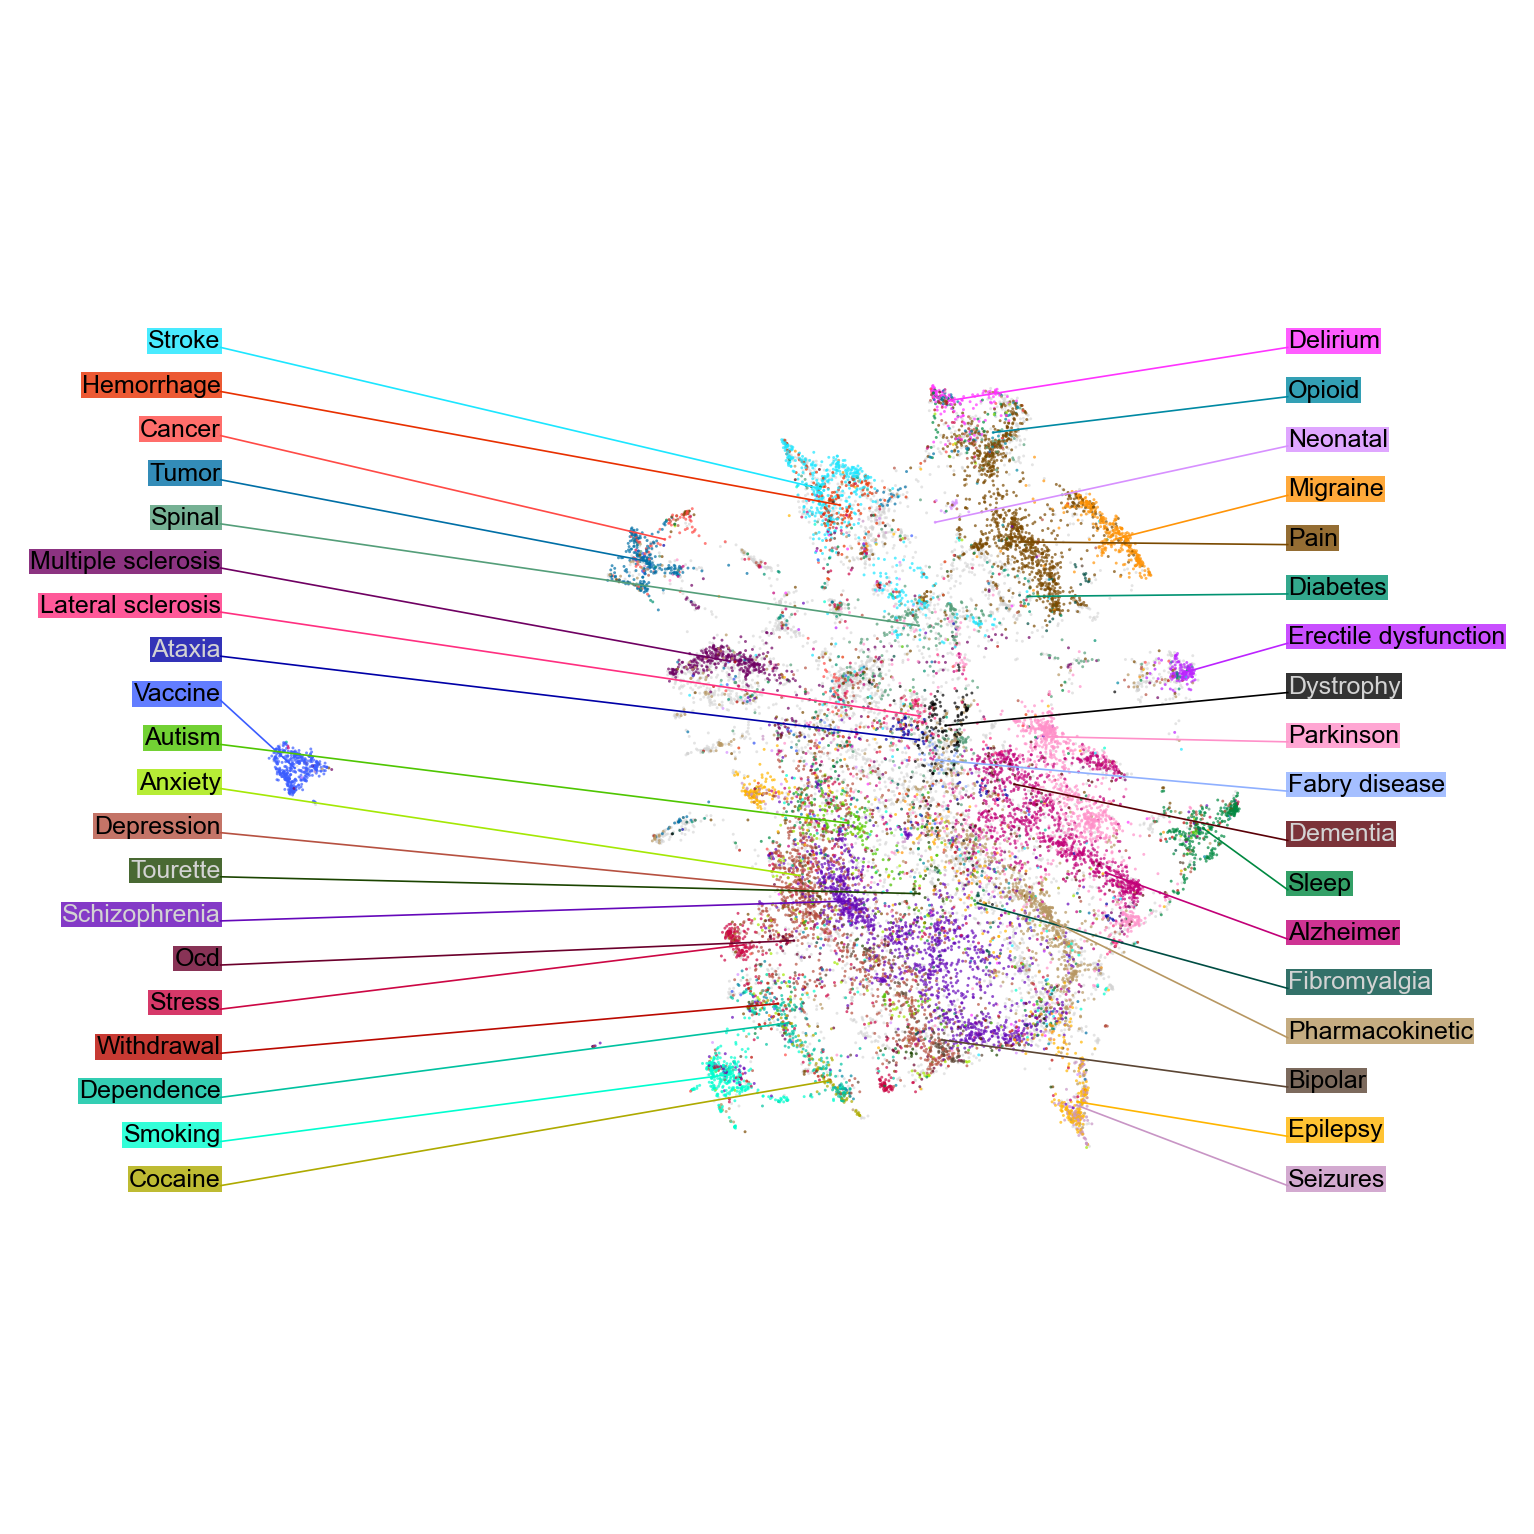

In [66]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(5, 5), dpi=300, layout="constrained")

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")

# Convert UMAP data to DataFrame for easier handling
df_umap = pd.DataFrame(umap, columns=["x", "y"])


# Function to calculate limits with padding
def calculate_limits(
    data, padding=0.05
):  # Smaller padding factor for more tightly fitted plot
    min_val = data.min()
    max_val = data.max()
    range_val = max_val - min_val
    padding_amount = range_val * padding
    return (min_val - padding_amount, max_val + padding_amount)


# Calculate x and y limits
x_lim = calculate_limits(df_umap["x"])
y_lim = calculate_limits(df_umap["y"])

# x_lim = (-11, 8)
# y_lim = (-11, 11)

plot_tsne_colors(
    umap, colors_new, ax=ax, x_lim=x_lim, y_lim=y_lim, plot_type="test"
)
plot_label_tags(
    umap,
    colors_new,
    colors_new_legend,
    x_lim=x_lim,
    y_lim=y_lim,
    ax=ax,
    fontsize=6,
    rs=2,
    subset=False,
)

fig.savefig(figures_path / "umap_colored_by_labels_pubmedbert.pdf", dpi=300)

### Interactive Plot

In [40]:
# Filter the DataFrame to keep only rows where "cluster" is "unlabeled"
unlabeled_df = df[df["cluster"] == "unlabeled"]

# Get the indices of the filtered DataFrame
unlabeled_indices = unlabeled_df.index

# Use the indices to filter the t-SNE coordinates
unlabeled_umap = umap[unlabeled_indices, :]

In [41]:
unlabeled_umap.shape

(5276, 2)

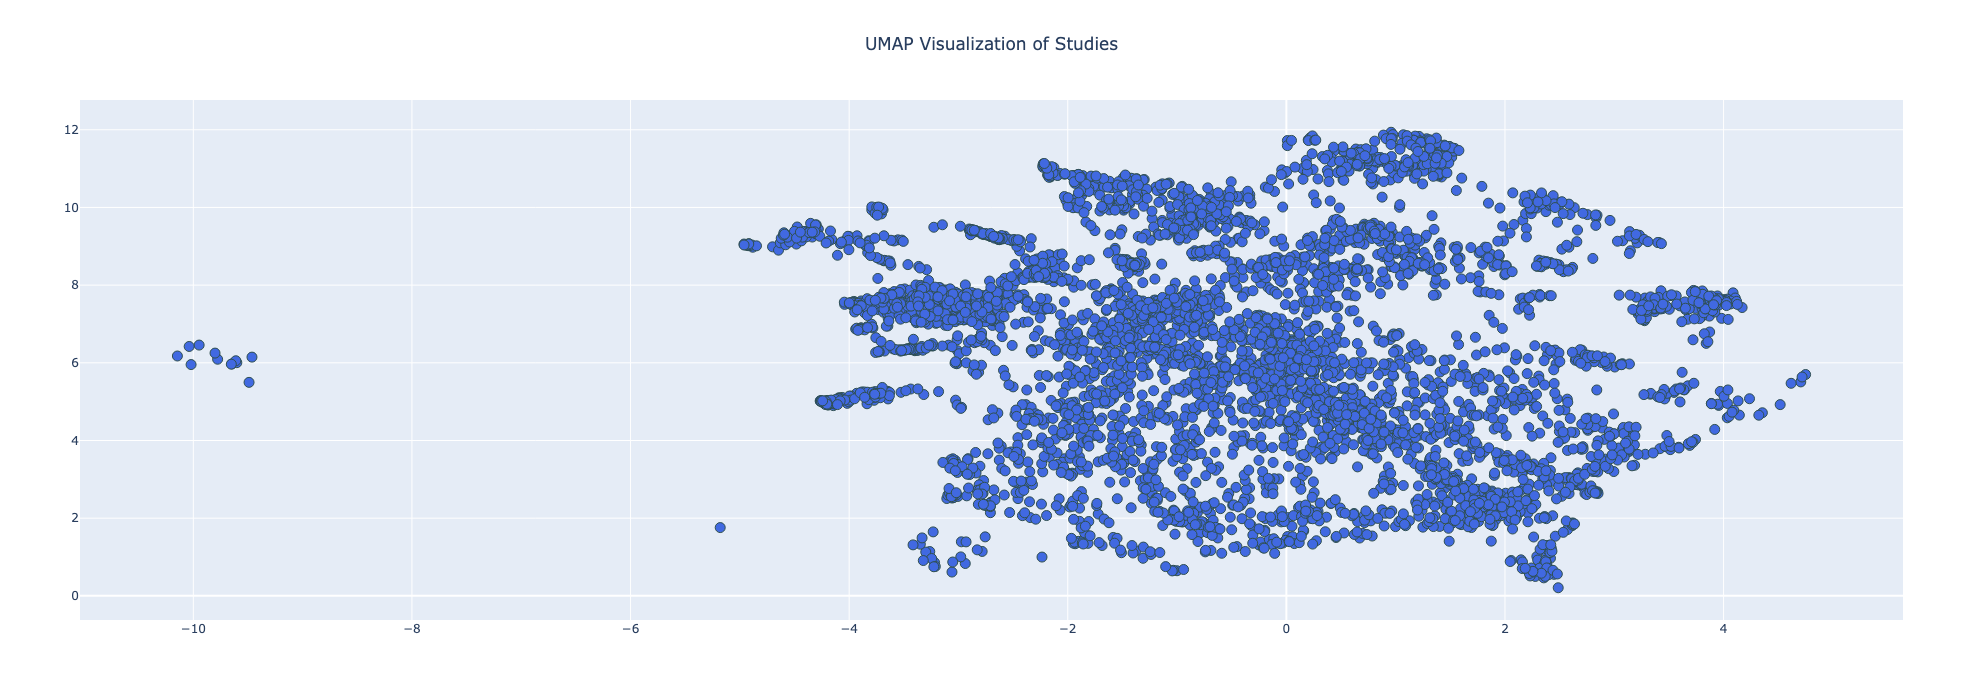

In [43]:
import plotly.graph_objects as go

# Assuming your t-SNE data is stored in a variable named `umap`
# And your DataFrame `df` contains a column 'study_official_title' for the official titles

fig = go.Figure()

# Add scatter plot for t-SNE data points
fig.add_trace(
    go.Scatter(
        x=unlabeled_umap[:, 0],  # Use your t-SNE x coordinates
        y=unlabeled_umap[:, 1],  # Use your t-SNE y coordinates
        mode="markers",
        marker=dict(
            color="RoyalBlue",  # Use a single color for all points
            size=10,  # Adjust the marker size here
            line=dict(width=1, color="DarkSlateGrey"),
        ),
        hovertemplate="<b>Title:</b> %{text}",
        text=unlabeled_df[
            "study_official_title"
        ],  # Make sure this points to the column with your official titles
        showlegend=False,  # Hide the legend for data points
    )
)

# Update plot size here
fig.update_layout(
    title="UMAP Visualization of Studies",
    title_x=0.5,
    width=900,  # Set the width of the plot
    height=700,  # Set the height of the plot
)
# Show the figure
fig.show()

## Colors by Phase

In [69]:
aact_data = pd.read_csv(
    "data/raw_aact/combined_neuro_trials_with_interventions_20240412.csv"
)
aact_data_phase = aact_data[["nct_id", "phase"]].drop_duplicates()
aact_data_phase

nct_id           phase
0       NCT03651726         Phase 2
5       NCT02326883  Not Applicable
14      NCT05262348  Not Applicable
20      NCT01550107         Phase 4
26      NCT04375436         Phase 1
...             ...             ...
503980  NCT02422303  Not Applicable
503983  NCT02714049         Phase 4
503987  NCT04408573  Not Applicable
503990  NCT03869463  Not Applicable
503994  NCT02691845  Not Applicable

[46376 rows x 2 columns]

In [70]:
df_with_phase = df.merge(aact_data_phase, on="nct_id", how="left")
df_phases = df_with_phase[["phase"]]

In [71]:
cluster_sizes = df_with_phase["phase"].value_counts()
cluster_sizes

phase
Phase 2            4675
Phase 3            3566
Not Applicable     3550
Phase 4            3254
Phase 1            2475
Phase 1/Phase 2     935
Phase 2/Phase 3     718
Early Phase 1       434
Name: count, dtype: int64

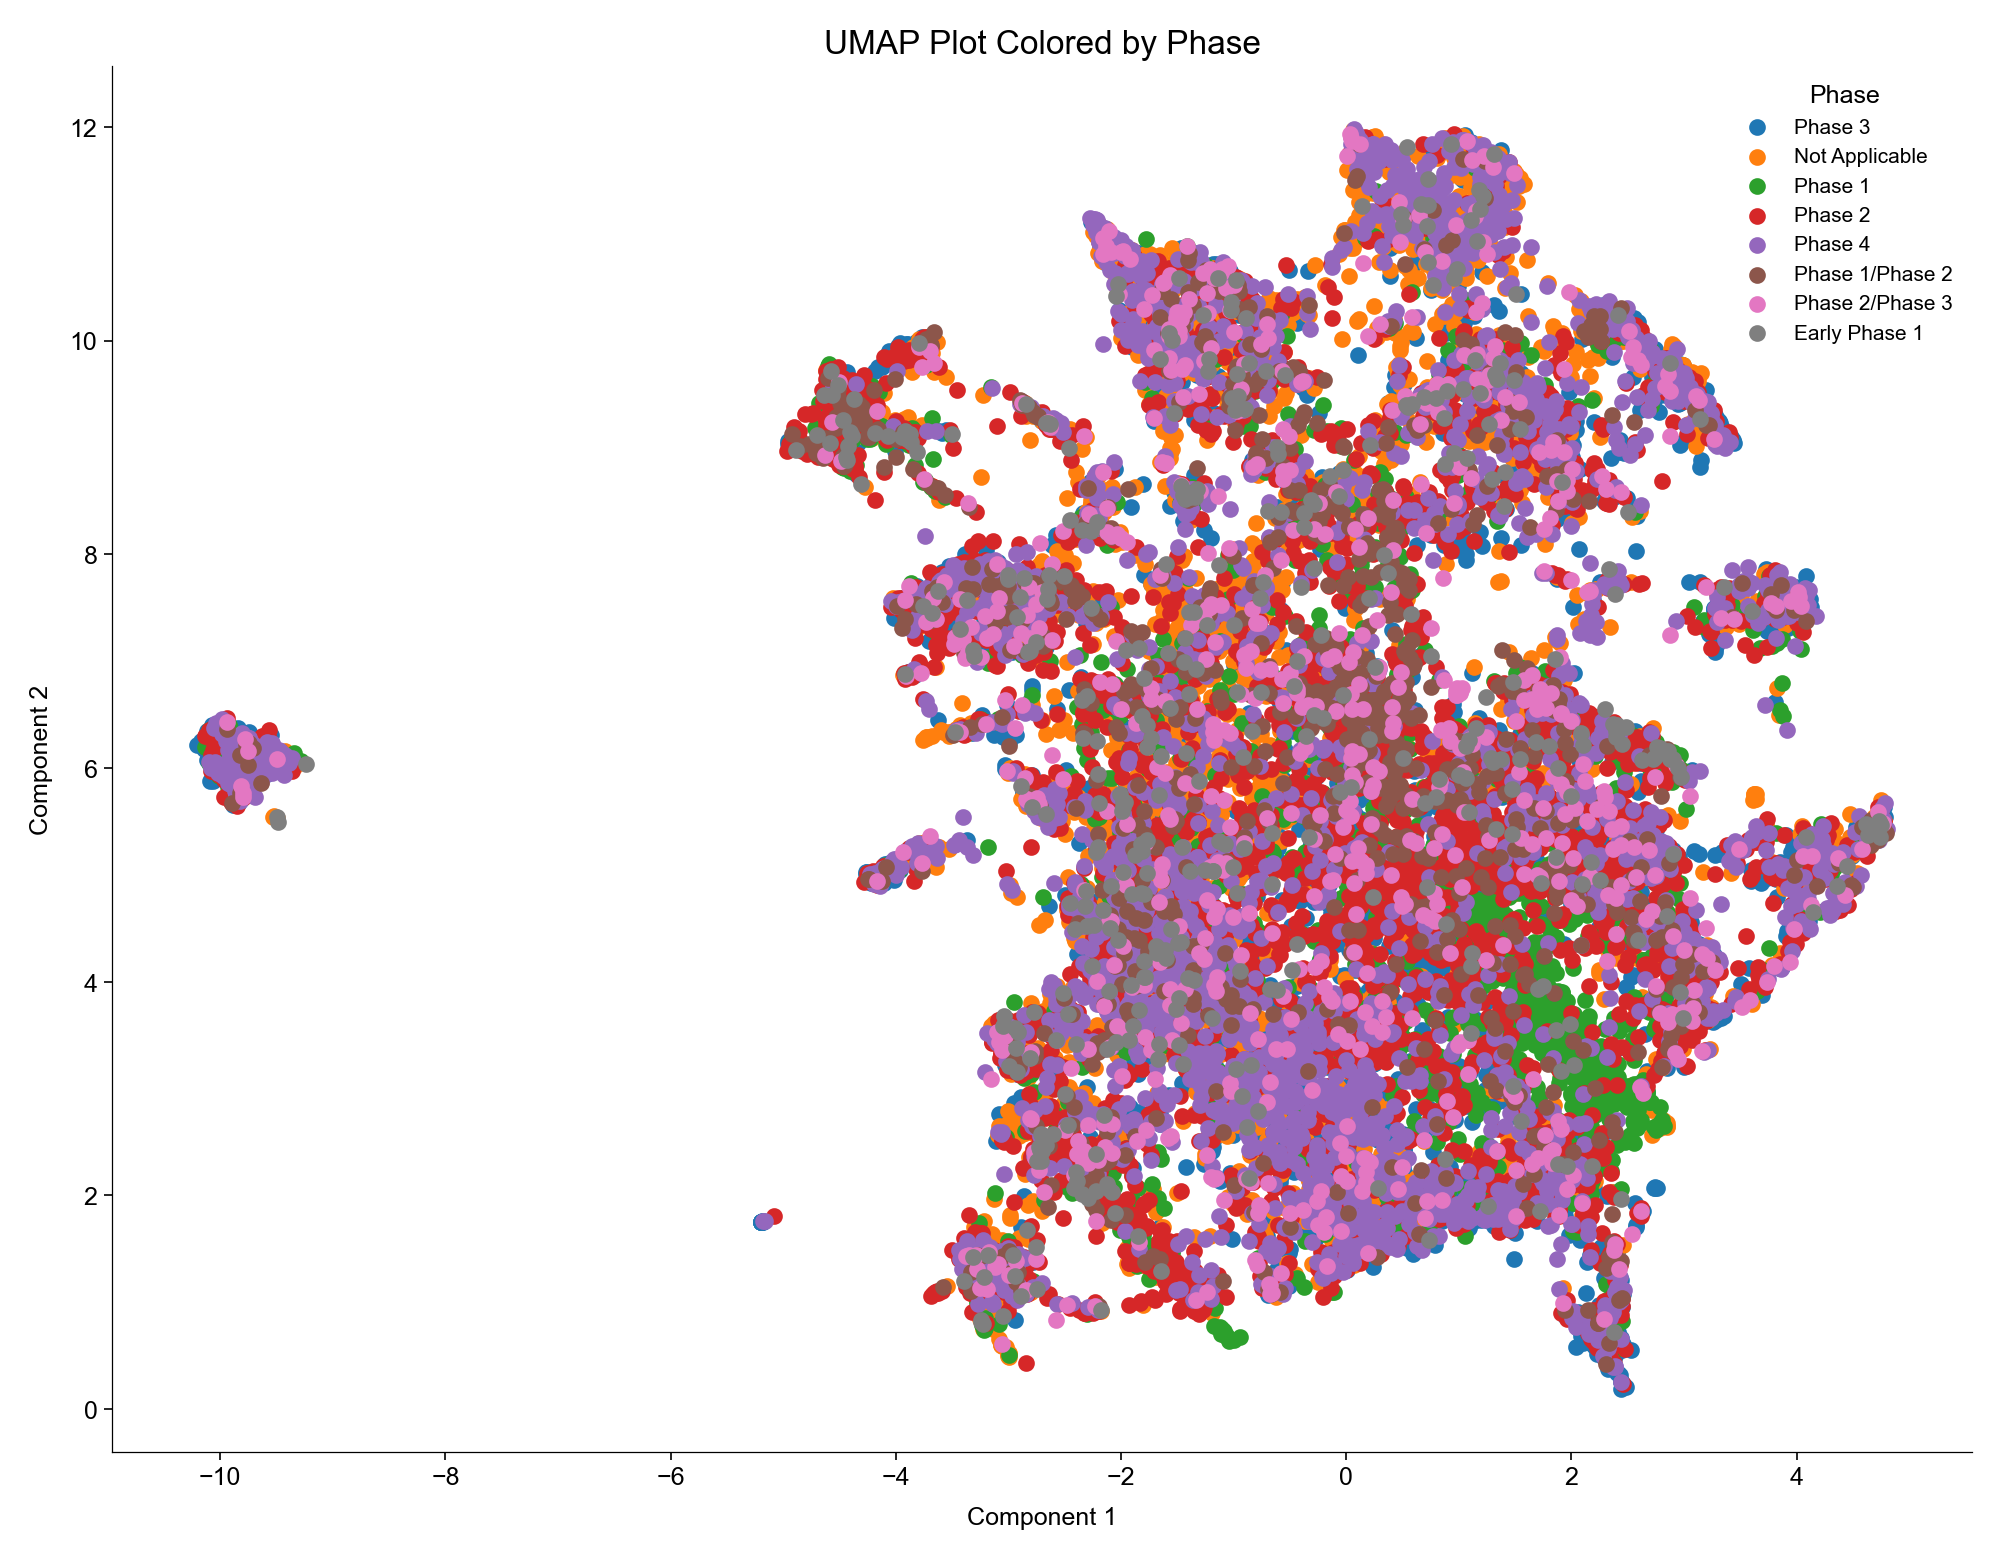

In [72]:
df_umap = pd.DataFrame(umap, columns=["x", "y"])

# Ensure the DataFrame with your phase data is aligned in row order with your t-SNE data
# Assuming it is already correctly aligned and has the same index

# Concatenate the t-SNE DataFrame with the phase DataFrame along the axis 1 (columns)
df = pd.concat([df_umap, df_phases], axis=1)

# Plot using matplotlib, coloring by phase
plt.figure(figsize=(8, 6))
for phase in df["phase"].unique():
    subset = df[df["phase"] == phase]
    plt.scatter(subset["x"], subset["y"], label=phase)

plt.title("UMAP Plot Colored by Phase")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Phase")
plt.show()

## Colors by year of publication

In [33]:
# Date
all_dates = clean_df_updated_reparsed_filtered_with_authors_ISSN["Date"]
unique_dates = np.unique(all_dates)

In [34]:
# Example of how the dates look like
print(unique_dates[20000:20010])

['2008 Jun 14' '2008 Jun 15' '2008 Jun 16' '2008 Jun 17' '2008 Jun 18'
 '2008 Jun 18-24' '2008 Jun 19' '2008 Jun 20' '2008 Jun 21' '2008 Jun 22']


In [6]:
%%time

# We do this to get the vocabulary, that divides the date strings in their different words

vectorizer = TfidfVectorizer(sublinear_tf=True)
tfidf_dates = vectorizer.fit_transform(unique_dates)
vocabulary_dates=vectorizer.vocabulary_

CPU times: user 116 ms, sys: 3.52 ms, total: 120 ms
Wall time: 121 ms


In [7]:
dates_list=list(vocabulary_dates.keys())
len_dates_list=map(len, dates_list)
len_dates=np.fromiter(len_dates_list, dtype=np.int64,count=len(dates_list))

dates_list=np.array(dates_list)
years=dates_list[len_dates==4]
print(list(years))

['1808', '1881', '1891', '1896', '1897', '1898', '1899', '1900', '1901', '1902', '1903', '1905', '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917', '1918', '1919', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', 'fall', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', 'june', 'july', '1996', '1997', '1998', '1999', '2000', '2004', '2001', '2002', '2003', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',

In [8]:
# eliminate manually the words that are not years
years = ['1808', '1881', '1891', '1896', '1897', '1898', '1899', '1900', '1901', '1902', 
 '1903', '1905', '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913', 
 '1914', '1915', '1916', '1917', '1918', '1919', '1920', '1921', '1922', '1923', 
 '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933', 
 '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1941', '1942', '1943', 
 '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1951', '1952', '1953', 
 '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', 
 '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', 
 '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', 
 '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', 
 '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', 
 '2004', '2001', '2002', '2003', '2005', '2006', '2007', '2008', '2009', '2010', 
 '2011', '2012', '2013', '2014', '2015', '2016', '2017', 
 '2018', '2019', '2020', '2021', '2022']

#save
np.save(variables_path / "years_reparsed",years)

In [9]:
# dicctionary years(number):color value

length_interval=2022-1970
cmap_values=np.linspace(0,1,length_interval+1)
year_numbers_list=np.arange(1970,2023).tolist()

dicc_years = dict(zip(year_numbers_list, cmap_values))

In [10]:
#save results
f = open(variables_path / "legend_years.pkl","wb")
pickle.dump(dicc_years,f)
f.close()

MEDLINE started its record in 1966 and later included almost 60 thousand noteworthy papers previously published. Therefore, the majority of the papers from PubMed are post 1970, so we used a color map going from blue (1970) to yellow (2022) and all of the papers dated before 1970 were also colored in the darkest hue of blue.

In [11]:
# We manually set papers dated from before 1970 to 0 (equivalent to the darkest hue).

years_out=[1808, 1881, 1891, 1896, 1897, 1898, 1899,1900, 1901, 1902, 1903, 1905, 1906, 1907, 1908, 
           1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 
           1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 
           1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 
           1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969] 

for elem in years_out:
    dicc_years[elem]=0

In [13]:
%%time

colors_per_year_reparsed, date_year = years_coloring(clean_df_updated_reparsed_filtered_with_authors_ISSN['Date'], years, dicc_years)

CPU times: user 17min 52s, sys: 24.7 s, total: 18min 17s
Wall time: 18min 17s


In [9]:
# save
np.save(variables_path / "colors_per_year_reparsed", colors_per_year_reparsed)

In [14]:
# save
np.save(variables_path / "date_year_reparsed", date_year)

### Plot

In [28]:
# save
colors_per_year_reparsed = np.load(
    variables_path / "colors_per_year_reparsed.npy"
)

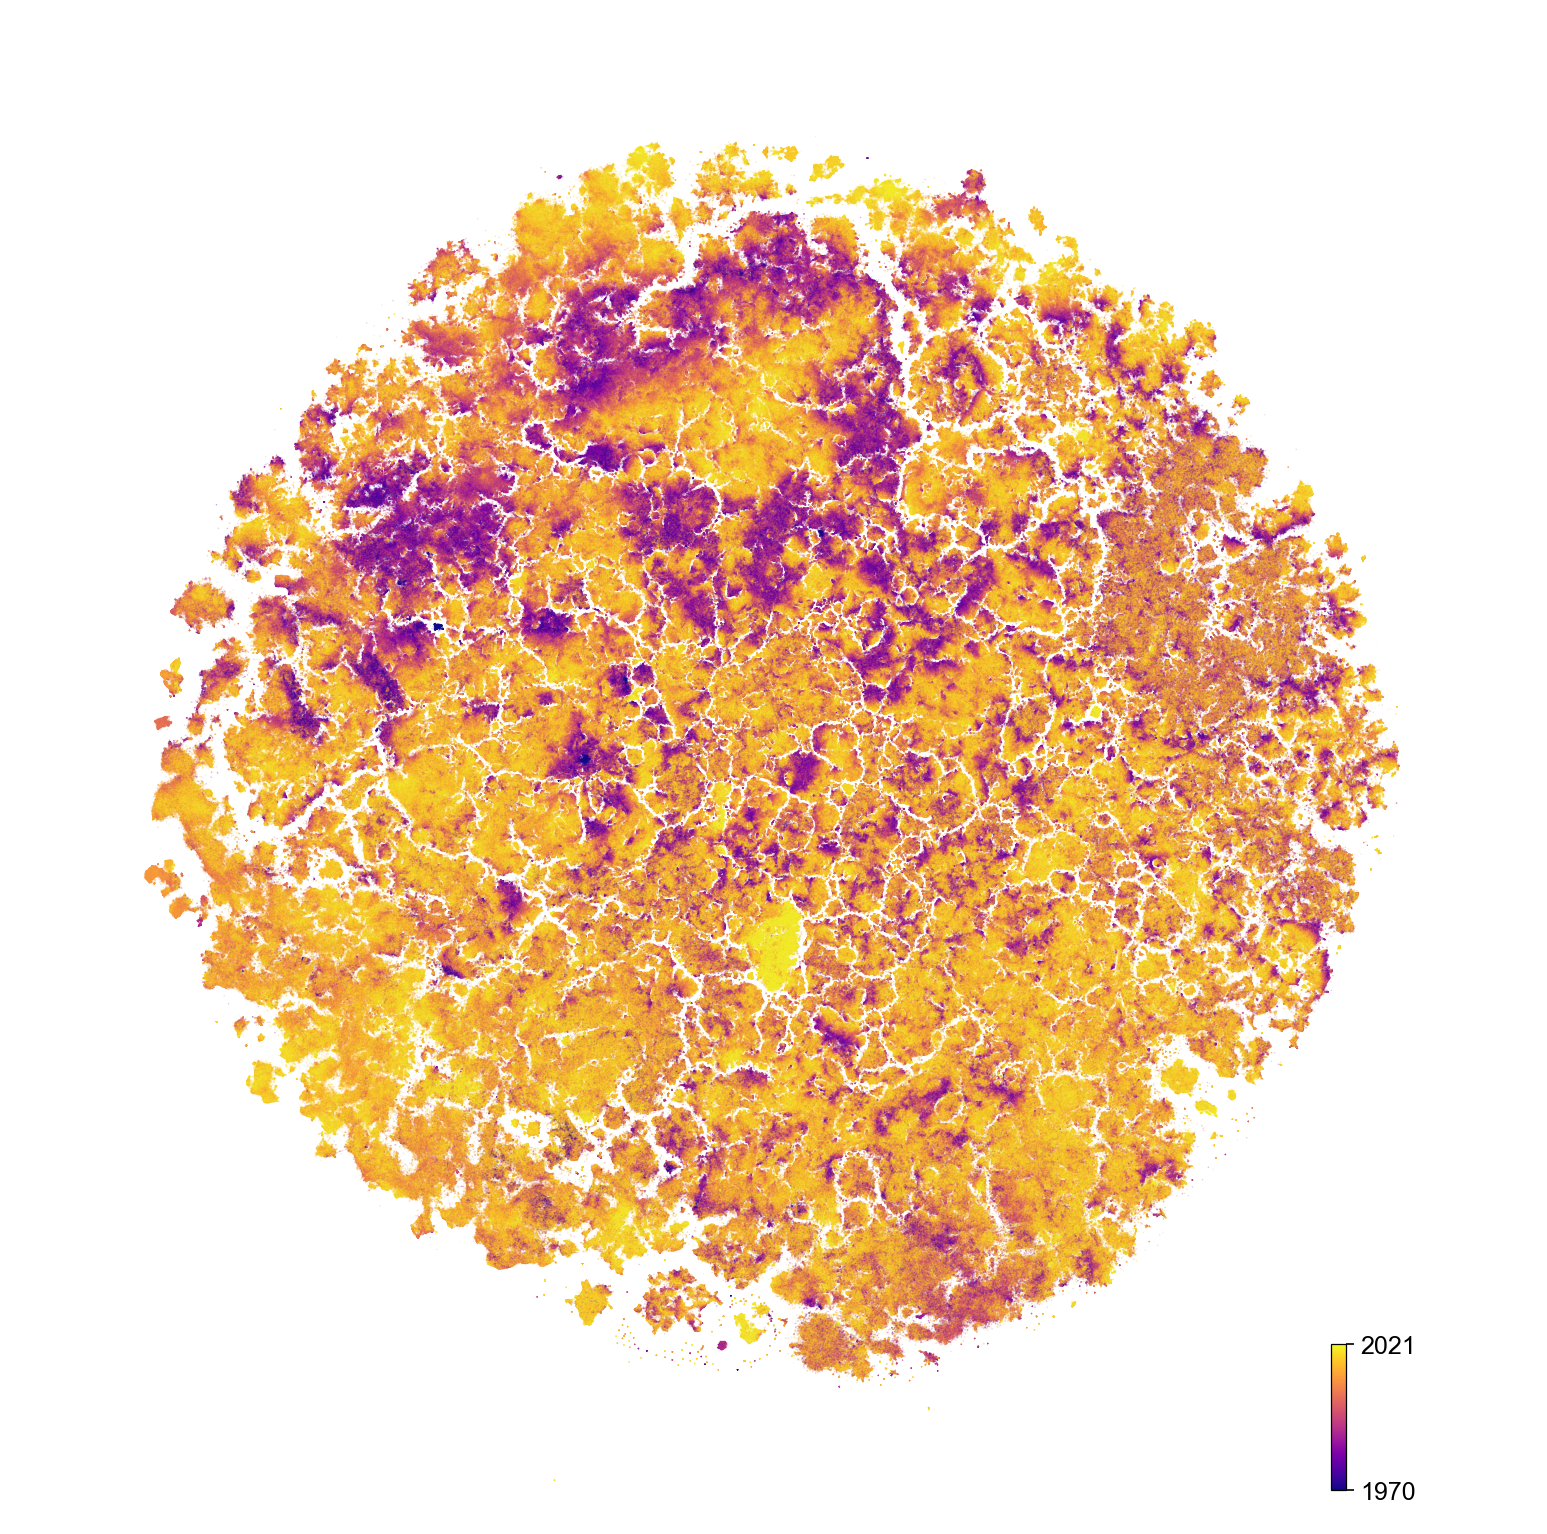

In [31]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(5, 5), dpi=300, layout="constrained")

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")
x_lim = (-230, 230)
y_lim = (-230, 230)

plot_umap_years(
    umap,
    colors_per_year_reparsed,
    x_lim=x_lim,
    y_lim=y_lim,
    ax=ax,
    fontsize=6,
    colorbar=True,
)

# fig.savefig(figures_path / "umap_colored_by_years.png", dpi=300)